In [151]:
import warnings
warnings.filterwarnings('ignore')

In [152]:
import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [153]:
os.chdir('d:\Projects\Codes\sichuan')

In [154]:
# 读取数据
root = './gr/dataset/prepropossed_versions'
version = '/version1' # 预处理的数据版本
train_data = pd.read_csv(root + version + '/train_data.csv')
# test_data = pd.read_csv(root + version + '/test_data.csv')
labels = pd.read_csv(root + version + '/train_target.csv')

In [155]:
# # 读取数据
# root = './gr/dataset/训练集'
# version = '' # 预处理的数据版本
# train_data = pd.read_csv(root + version + '/train_data.csv')
# # test_data = pd.read_csv(root + version + '/test_data.csv')
# labels = pd.read_csv(root + version + '/train_target.csv')
# train_data.drop('idx', axis=1, inplace=True)
# # 正则化
# train_data = (train_data - train_data.mean()) / train_data.std()

In [156]:
# 分割数据集
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc

train_data1, test_data1, labels_train1, labels_test1 = train_test_split(train_data, labels['date'], test_size=0.2, random_state=42)

In [157]:
import xgboost as xgb
from sklearn.utils import class_weight

def train_xgboostregressor(train_data, labels_train, test_data, labels_test):
    # 定义xgboost模型
    model = xgb.XGBRegressor(n_estimators=200, learning_rate=0.1)
    # 训练模型
    model.fit(train_data, labels_train)
    # 预测结果
    predictions = model.predict(test_data)
    # 计算MSE
    mse = ((predictions - labels_test) ** 2).mean()
    print("MSE: %.2f" % mse)

    return model, predictions

def train_xgboostclassifier(train_data, labels_train, test_data, labels_test):
    # 计算类别权重
    class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(labels_train), y=labels_train)
    weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
    # 定义xgboost模型
    model = xgb.XGBClassifier(n_estimators=200, learning_rate=0.1, class_weight=weight_dict)
    # 训练模型
    model.fit(train_data, labels_train)
    # 预测结果
    predictions = model.predict(test_data)
    probabilities = model.predict(test_data, output_margin=False)
    print(probabilities)

    print(classification_report(labels_test, predictions))
    # 计算roc曲线参数
    fpr, tpr, thresholds = roc_curve(labels_test, probabilities)
    # 计算AUC
    auc_score = auc(fpr, tpr)

    return model, predictions, auc, fpr, tpr, thresholds

回归date并合并到原始数据集

In [158]:
# 对date回归
model, predictions = train_xgboostregressor(train_data1, labels_train1, test_data1, labels_test1)

MSE: 369.87


In [159]:
all_predictions = model.predict(train_data)
all_predictions

array([ 5.176954,  4.935833,  6.84403 , ..., 10.614234,  8.651672,
       23.107803], dtype=float32)

In [160]:
train_data['date_reg'] = all_predictions
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61866 entries, 0 to 61865
Columns: 143 entries, g1_pca_0 to date_reg
dtypes: float32(1), float64(142)
memory usage: 67.3 MB


使用date回归出的特征跑模型

In [161]:
train_data2, test_data2, train_label2, test_label2 = train_test_split(train_data, labels['y'], test_size=0.2, random_state=42)
model_c, predictions, auc_score, fpr, tpr, thresholds = train_xgboostclassifier(train_data2, train_label2, test_data2, test_label2)

[0 0 0 ... 0 0 0]
              precision    recall  f1-score   support

         0.0       0.82      0.99      0.90     10095
         1.0       0.45      0.03      0.06      2279

    accuracy                           0.81     12374
   macro avg       0.64      0.51      0.48     12374
weighted avg       0.75      0.81      0.74     12374



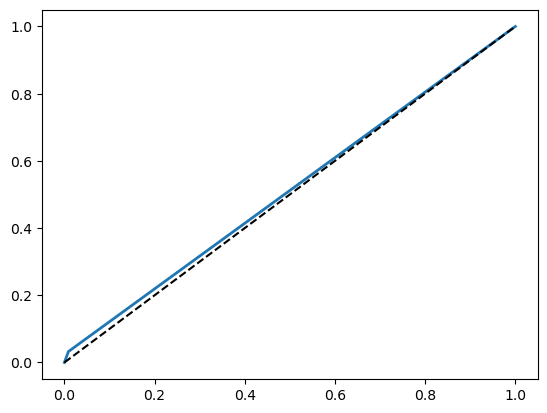

In [162]:
# 绘制roc曲线
import matplotlib.pyplot as plt

plt.plot(fpr, tpr, linewidth=2, label=f'ROC curve (area = {auc_score})')
plt.plot([0, 1], [0, 1], 'k--')

plt.show()

In [163]:
# date特征的重要性
features_importance = {train_data2.columns[i]:model_c.feature_importances_[i] for i in range(train_data2.shape[1])}

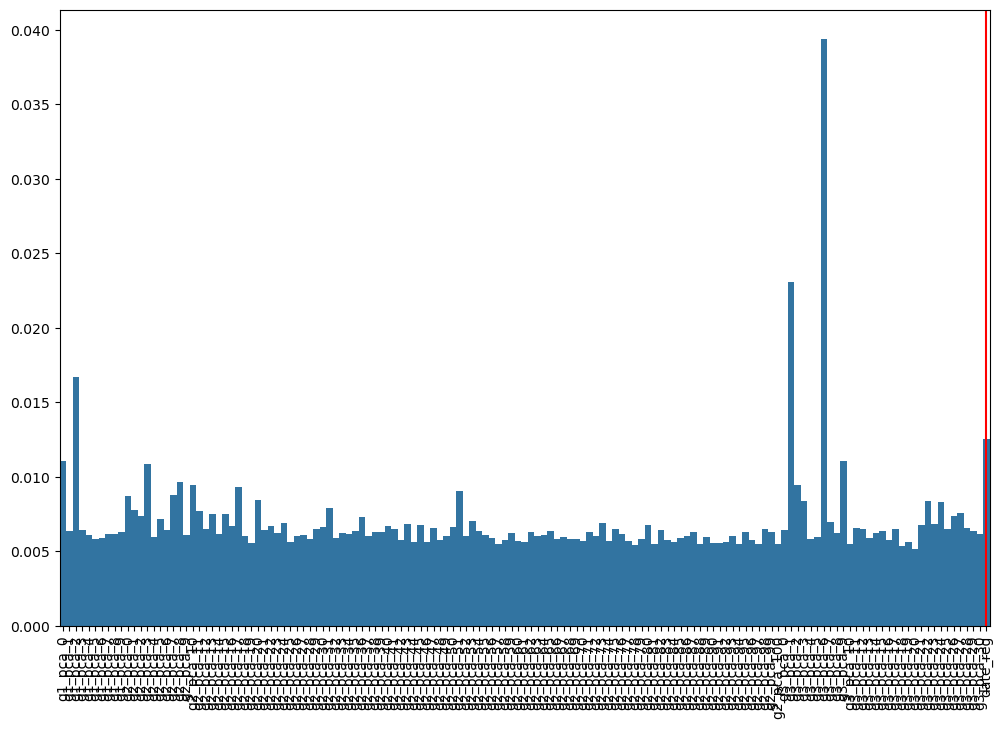

In [164]:
# 绘制特征重要性
plt.figure(figsize=(12, 8))
sns.barplot(x=list(features_importance.keys()), y=list(features_importance.values()), width=1)
plt.xticks(rotation=90)
# 将date特征列标红
plt.axvline(x=list(features_importance.keys())[-1], color='r')
plt.show()

不使用date_reg特征跑模型

In [165]:
train_data2, test_data2, train_label2, test_label2 = train_test_split(
    train_data.drop("date_reg", axis=1), labels["y"], test_size=0.2, random_state=42
)
model_c, predictions, auc_score, fpr, tpr, thresholds = train_xgboostclassifier(
    train_data2, train_label2, test_data2, test_label2
)

[0 0 0 ... 0 0 0]
              precision    recall  f1-score   support

         0.0       0.82      0.99      0.90     10095
         1.0       0.49      0.03      0.06      2279

    accuracy                           0.82     12374
   macro avg       0.65      0.51      0.48     12374
weighted avg       0.76      0.82      0.74     12374



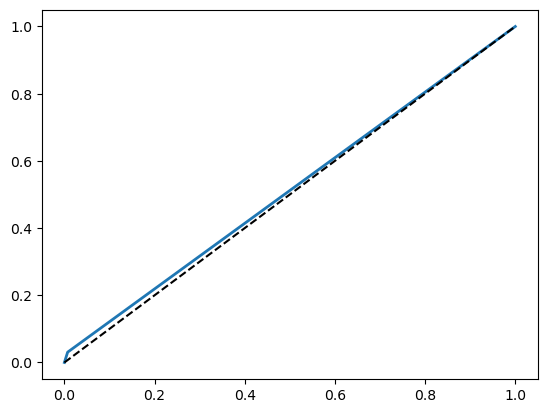

In [166]:
# 绘制roc曲线
import matplotlib.pyplot as plt

plt.plot(fpr, tpr, linewidth=2, label=f'ROC curve (area = {auc_score})')
plt.plot([0, 1], [0, 1], 'k--')

plt.show()